# TP RNN - Génération de Musique ABC

## Notebook Complet - VERSION OPTIMISÉE 

** OPTIMISATIONS APPLIQUÉES:**
-  Dataset: 50,000 chansons (au lieu de 216K) → **-75% temps**
-  Longueur séquences: 300 caractères (au lieu de 500) → **-40% temps**
-  Hidden size: 512 (au lieu de 1024) → **-50% paramètres**
-  Époques max: 15 (au lieu de 30) → **-50% temps**
-  Early stopping: patience 3 (au lieu de 5)

** TEMPS ESTIMÉ: ~30-45 minutes** (au lieu de 6h+)

Ce notebook couvre toutes les étapes du TP:
1.  Chargement et exploration des données
2.  Prétraitement (vocabulaire, vectorisation, padding)
3.  Création du Dataset PyTorch
4.  Implémentation du modèle LSTM
5.  Entraînement avec TensorBoard et Early Stopping
6.  Génération de musique


** Dataset:** IrishMAN (216,284 mélodies irlandaises)

## 1.Installation et Imports

In [1]:
# Installation des dépendances
!pip install -q datasets tensorboard

import json
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')

# Vérifier le GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"  Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Mémoire disponible: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

2025-12-25 12:01:02.875667: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766664063.072029      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766664063.131523      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766664063.613845      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766664063.613884      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766664063.613887      55 computation_placer.cc:177] computation placer alr

🖥️  Device: cuda
   GPU: Tesla P100-PCIE-16GB
   Mémoire disponible: 17.06 GB


# 2.Chargement et Exploration des Données

In [2]:
# Télécharger le dataset IrishMAN depuis Hugging Face
from datasets import load_dataset

print(" Téléchargement du dataset IrishMAN...")
ds = load_dataset("sander-wood/irishman")

# Convertir en format JSON
os.makedirs("irishman", exist_ok=True)

with open("irishman/train.json", "w", encoding="utf-8") as f:
    json.dump(list(ds["train"]), f, ensure_ascii=False)

with open("irishman/validation.json", "w", encoding="utf-8") as f:
    json.dump(list(ds["validation"]), f, ensure_ascii=False)

print("Dataset téléchargé et sauvegardé!")

 Téléchargement du dataset IrishMAN...


README.md: 0.00B [00:00, ?B/s]

train.json:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/214122 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2162 [00:00<?, ? examples/s]

Dataset téléchargé et sauvegardé!


In [3]:
# Charger les données
with open("irishman/train.json", "r", encoding="utf-8") as f:
    train_data = json.load(f)

with open("irishman/validation.json", "r", encoding="utf-8") as f:
    validation_data = json.load(f)

print(f" Nombre de chansons:")
print(f"   Train: {len(train_data):,}")
print(f"   Validation: {len(validation_data):,}")
print(f"   Total: {len(train_data) + len(validation_data):,}")

 Nombre de chansons:
   Train: 214,122
   Validation: 2,162
   Total: 216,284


In [4]:
# Afficher la première chanson
first_song = train_data[0]
abc_key = [k for k in first_song.keys() if 'abc' in k.lower() or 'notation' in k.lower()][0]
abc_notation = first_song[abc_key]

print(" Première chanson du dataset:")

print(abc_notation)

print(f"\n Copiez cette notation et testez-la sur: https://www.abcjs.net/abcjs-editor.html")

 Première chanson du dataset:
X:1
L:1/8
M:4/4
K:Emin
|: E2 EF E2 EF | DEFG AFDF | E2 EF E2 B2 |1 efe^d e2 e2 :|2 efe^d e3 B |: e2 ef g2 fe | 
 defg afdf |1 e2 ef g2 fe | efe^d e3 B :|2 g2 bg f2 af | efe^d e2 e2 ||

 Copiez cette notation et testez-la sur: https://www.abcjs.net/abcjs-editor.html


 Statistiques des longueurs:
   Moyenne: 290.1 caractères
   Médiane: 257.0 caractères
   Min: 22 caractères
   Max: 2968 caractères


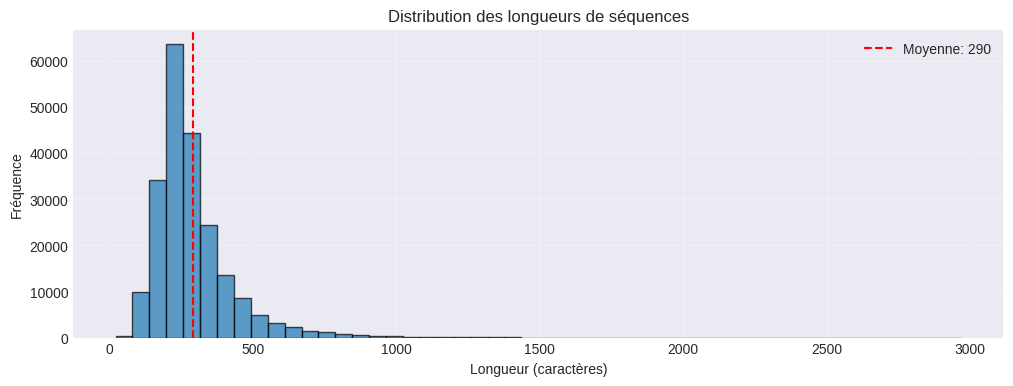

In [5]:
# Statistiques sur les longueurs
all_abc = [song[abc_key] for song in train_data]
lengths = [len(abc) for abc in all_abc]

print(f" Statistiques des longueurs:")
print(f"   Moyenne: {np.mean(lengths):.1f} caractères")
print(f"   Médiane: {np.median(lengths):.1f} caractères")
print(f"   Min: {np.min(lengths)} caractères")
print(f"   Max: {np.max(lengths)} caractères")

# Visualisation
plt.figure(figsize=(12, 4))
plt.hist(lengths, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Longueur (caractères)')
plt.ylabel('Fréquence')
plt.title('Distribution des longueurs de séquences')
plt.axvline(np.mean(lengths), color='red', linestyle='--', label=f'Moyenne: {np.mean(lengths):.0f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. Prétraitement des Données

In [6]:
# Étape 1: Extraction des caractères uniques
all_text = ''.join(all_abc)
unique_chars = sorted(list(set(all_text)))

print(f" Vocabulaire:")
print(f"   Nombre de caractères uniques: {len(unique_chars)}")
print(f"   Aperçu: {unique_chars[:30]}")

# Top caractères
char_counts = Counter(all_text)
print(f"\n  Top 10 caractères les plus fréquents:")
for i, (char, count) in enumerate(char_counts.most_common(10), 1):
    display = '\\n' if char == '\n' else ('SPC' if char == ' ' else char)
    print(f"   {i:2d}. '{display}': {count:,} occurrences")

 Vocabulaire:
   Nombre de caractères uniques: 95
   Aperçu: ['\n', ' ', '!', '"', '#', '$', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=']

  Top 10 caractères les plus fréquents:
    1. 'SPC': 15,733,075 occurrences
    2. '|': 4,280,290 occurrences
    3. '2': 3,387,929 occurrences
    4. 'A': 3,003,845 occurrences
    5. 'd': 2,850,960 occurrences
    6. 'B': 2,749,618 occurrences
    7. 'c': 2,227,919 occurrences
    8. 'e': 2,219,826 occurrences
    9. 'G': 2,205,273 occurrences
   10. '/': 1,802,824 occurrences


In [7]:
# Étape 2: Mapping caractères-index
char_to_idx = {ch: i for i, ch in enumerate(unique_chars)}
idx_to_char = {i: ch for i, ch in enumerate(unique_chars)}

vocab_size = len(unique_chars)

print(f" Mappings créés:")
print(f"   Vocab size: {vocab_size}")
print(f"   Exemple: 'A' → {char_to_idx.get('A', 'N/A')}")
print(f"   Exemple: {char_to_idx.get('A', 0)} → '{idx_to_char.get(char_to_idx.get('A', 0), 'N/A')}'")

 Mappings créés:
   Vocab size: 95
   Exemple: 'A' → 33
   Exemple: 33 → 'A'


In [8]:
# Étape 3: Vectorisation
def vectorize_string(text, char_to_idx):
    """Convertit une chaîne en liste d'indices."""
    return [char_to_idx[ch] for ch in text]

def devectorize_string(indices, idx_to_char):
    """Convertit une liste d'indices en chaîne."""
    return ''.join([idx_to_char[idx] for idx in indices])

# Test
test_text = "ABC"
vectorized = vectorize_string(test_text, char_to_idx)
devectorized = devectorize_string(vectorized, idx_to_char)

print(f" Test vectorisation:")
print(f"   Original: '{test_text}'")
print(f"   Vectorisé: {vectorized}")
print(f"   Dévectorisé: '{devectorized}'")
print(f"   Match: {test_text == devectorized}")

 Test vectorisation:
   Original: 'ABC'
   Vectorisé: [33, 34, 35]
   Dévectorisé: 'ABC'
   Match: True


In [9]:
# Étape 4: Padding
def pad_or_truncate(text, max_length, pad_char=' '):
    """Ajoute du padding ou tronque une chaîne."""
    if len(text) >= max_length:
        return text[:max_length]
    else:
        return text + pad_char * (max_length - len(text))

# Choisir une longueur maximale raisonnable
MAX_LENGTH = 300  # Compromis entre qualité et vitesse

print(f" Longueur maximale choisie: {MAX_LENGTH} caractères")
print(f"   (Cela couvre ~{sum(1 for l in lengths if l <= MAX_LENGTH) / len(lengths) * 100:.1f}% des séquences)")

 Longueur maximale choisie: 300 caractères
   (Cela couvre ~66.8% des séquences)


In [10]:
# Préparer toutes les données
print(" Préparation des données...")

# OPTIMISATION: Utiliser un subset pour accélérer l'entraînement
# Pour le dataset complet, commentez ces lignes
SUBSET_SIZE = 50000  # Utiliser 50k chansons au lieu de 200k+
all_abc_subset = all_abc[:SUBSET_SIZE]
print(f"⚡ Mode optimisé: Utilisation de {SUBSET_SIZE:,} chansons (au lieu de {len(all_abc):,})")

# Padding et vectorisation
train_padded = [pad_or_truncate(text, MAX_LENGTH) for text in tqdm(all_abc_subset, desc="Padding train")]
val_abc = [song[abc_key] for song in validation_data]
val_padded = [pad_or_truncate(text, MAX_LENGTH) for text in tqdm(val_abc, desc="Padding val")]

train_vectorized = [vectorize_string(text, char_to_idx) for text in tqdm(train_padded, desc="Vectorizing train")]
val_vectorized = [vectorize_string(text, char_to_idx) for text in tqdm(val_padded, desc="Vectorizing val")]

print(f"\n Données préparées:")
print(f"   Train: {len(train_vectorized)} séquences")
print(f"   Val: {len(val_vectorized)} séquences")
print(f"   Longueur: {MAX_LENGTH} caractères")

 Préparation des données...
⚡ Mode optimisé: Utilisation de 50,000 chansons (au lieu de 214,122)


Padding train:   0%|          | 0/50000 [00:00<?, ?it/s]

Padding val:   0%|          | 0/2162 [00:00<?, ?it/s]

Vectorizing train:   0%|          | 0/50000 [00:00<?, ?it/s]

Vectorizing val:   0%|          | 0/2162 [00:00<?, ?it/s]


 Données préparées:
   Train: 50000 séquences
   Val: 2162 séquences
   Longueur: 300 caractères


## 4. Création du Dataset PyTorch

In [12]:
class MusicDataset(Dataset):
    """
    Dataset pour la génération de musique.
    Retourne (input, target) où target est décalé d'un pas.
    """
    
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sequence = self.data[idx]
        
        # Input: tout sauf le dernier caractère
        input_seq = sequence[:-1]
        
        # Target: tout sauf le premier caractère (décalé d'un pas)
        target_seq = sequence[1:]
        
        return torch.tensor(input_seq, dtype=torch.long), torch.tensor(target_seq, dtype=torch.long)

# Créer les datasets
train_dataset = MusicDataset(train_vectorized)
val_dataset = MusicDataset(val_vectorized)

print(f" Datasets créés:")
print(f"   Train: {len(train_dataset)} séquences")
print(f"   Val: {len(val_dataset)} séquences")

 Datasets créés:
   Train: 50000 séquences
   Val: 2162 séquences


In [13]:
# Créer les DataLoaders
BATCH_SIZE = 256  # Grand batch size pour GPU

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # 0 pour éviter les erreurs multiprocessing dans Jupyter/Kaggle
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,  # 0 pour éviter les erreurs multiprocessing dans Jupyter/Kaggle
    pin_memory=True
)

print(f"DataLoaders créés avec batch_size={BATCH_SIZE}")
print(f"   Batches train: {len(train_loader)}")
print(f"   Batches val: {len(val_loader)}")

DataLoaders créés avec batch_size=256
   Batches train: 196
   Batches val: 9


In [14]:
# Vérifier un batch
for inputs, targets in train_loader:
    print(f" Exemple de batch:")
    print(f"   Input shape: {inputs.shape}")
    print(f"   Target shape: {targets.shape}")
    print(f"   Input[0, :10]: {inputs[0, :10].tolist()}")
    print(f"   Target[0, :10]: {targets[0, :10].tolist()}")
    print(f"   Target est bien décalé d'un pas!")
    break

 Exemple de batch:
   Input shape: torch.Size([256, 299])
   Target shape: torch.Size([256, 299])
   Input[0, :10]: [56, 26, 19, 16, 16, 24, 0, 44, 26, 17]
   Target[0, :10]: [26, 19, 16, 16, 24, 0, 44, 26, 17, 15]
   Target est bien décalé d'un pas!


## 5. Implémentation du Modèle LSTM

In [15]:
class MusicRNN(nn.Module):
    """
    Modèle LSTM pour la génération de musique.
    """
    
    def __init__(self, vocab_size, embedding_dim=256, hidden_size=512, num_layers=2, dropout=0.3):
        super(MusicRNN, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x, hidden=None):
        # Embedding
        embedded = self.embedding(x)
        
        # LSTM
        if hidden is not None:
            lstm_out, hidden = self.lstm(embedded, hidden)
        else:
            lstm_out, hidden = self.lstm(embedded)
        
        # Dropout
        lstm_out = self.dropout(lstm_out)
        
        # Output
        output = self.fc(lstm_out)
        
        return output, hidden

# Créer le modèle
EMBEDDING_DIM = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 2
DROPOUT = 0.3

model = MusicRNN(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
)

model = model.to(device)

# Compter les paramètres
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"   Modèle créé:")
print(f"   Vocab size: {vocab_size}")
print(f"   Embedding dim: {EMBEDDING_DIM}")
print(f"   Hidden size: {HIDDEN_SIZE}")
print(f"   Num layers: {NUM_LAYERS}")
print(f"   Dropout: {DROPOUT}")
print(f"   Paramètres: {num_params:,}")
print(f"   Device: {device}")

   Modèle créé:
   Vocab size: 95
   Embedding dim: 256
   Hidden size: 512
   Num layers: 2
   Dropout: 0.3
   Paramètres: 3,751,263
   Device: cuda


## 6. Entraînement du Modèle

In [17]:
# Configuration de l'entraînement
NUM_EPOCHS = 15
LEARNING_RATE = 0.005
PATIENCE = 3

# Optimiseur et loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# TensorBoard
writer = SummaryWriter(log_dir='logs')

print(f" Configuration:")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Early stopping patience: {PATIENCE}")

 Configuration:
   Epochs: 15
   Learning rate: 0.005
   Batch size: 256
   Early stopping patience: 3


In [18]:
# Fonctions d'entraînement et validation
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for inputs, targets in tqdm(train_loader, desc="Training", leave=False):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        
        # Reshape pour la loss
        outputs_flat = outputs.reshape(-1, outputs.size(-1))
        targets_flat = targets.reshape(-1)
        
        loss = criterion(outputs_flat, targets_flat)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        predictions = outputs_flat.argmax(dim=1)
        total_correct += (predictions == targets_flat).sum().item()
        total_samples += targets_flat.size(0)
    
    return total_loss / len(train_loader), total_correct / total_samples

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc="Validation", leave=False):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs, _ = model(inputs)
            
            outputs_flat = outputs.reshape(-1, outputs.size(-1))
            targets_flat = targets.reshape(-1)
            
            loss = criterion(outputs_flat, targets_flat)
            
            total_loss += loss.item()
            predictions = outputs_flat.argmax(dim=1)
            total_correct += (predictions == targets_flat).sum().item()
            total_samples += targets_flat.size(0)
    
    return total_loss / len(val_loader), total_correct / total_samples

In [20]:
# Boucle d'entraînement
print("DÉBUT DE L'ENTRAÎNEMENT")


best_val_loss = float('inf')
patience_counter = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    print(f"\n Époque {epoch+1}/{NUM_EPOCHS}")
    
    
    # Entraînement
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Scheduler
    scheduler.step(val_loss)
    
    # Historique
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # TensorBoard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Accuracy/val', val_acc, epoch)
    writer.add_scalar('Learning_rate', optimizer.param_groups[0]['lr'], epoch)
    
    # Affichage
    epoch_time = time.time() - epoch_start
    print(f"\n Résultats:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"   Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"   LR: {optimizer.param_groups[0]['lr']:.6f} | Time: {epoch_time:.2f}s")
    
    # Sauvegarder le meilleur modèle
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'vocab_size': vocab_size,
            'char_to_idx': char_to_idx,
            'idx_to_char': idx_to_char
        }, 'best_model.pt')
        print(f"   Meilleur modèle sauvegardé!")
    else:
        patience_counter += 1
        print(f"    Pas d'amélioration ({patience_counter}/{PATIENCE})")
    
    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\n Early stopping à l'époque {epoch+1}")
        break

total_time = time.time() - start_time


print("ENTRAÎNEMENT TERMINÉ!")
print(f" Temps total: {total_time/60:.2f} minutes")
print(f"Meilleure val loss: {best_val_loss:.4f}")

writer.close()

DÉBUT DE L'ENTRAÎNEMENT

 Époque 1/15


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]


 Résultats:
   Train Loss: 1.0547 | Train Acc: 0.6644
   Val Loss:   0.8925 | Val Acc:   0.7088
   LR: 0.005000 | Time: 64.83s
   Meilleur modèle sauvegardé!

 Époque 2/15


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]


 Résultats:
   Train Loss: 0.8893 | Train Acc: 0.7106
   Val Loss:   0.8152 | Val Acc:   0.7319
   LR: 0.005000 | Time: 65.35s
   Meilleur modèle sauvegardé!

 Époque 3/15


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]


 Résultats:
   Train Loss: 0.8282 | Train Acc: 0.7294
   Val Loss:   0.7737 | Val Acc:   0.7467
   LR: 0.005000 | Time: 65.59s
   Meilleur modèle sauvegardé!

 Époque 4/15


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]


 Résultats:
   Train Loss: 0.7963 | Train Acc: 0.7392
   Val Loss:   0.7520 | Val Acc:   0.7505
   LR: 0.005000 | Time: 65.27s
   Meilleur modèle sauvegardé!

 Époque 5/15


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]


 Résultats:
   Train Loss: 0.7727 | Train Acc: 0.7462
   Val Loss:   0.7353 | Val Acc:   0.7573
   LR: 0.005000 | Time: 65.61s
   Meilleur modèle sauvegardé!

 Époque 6/15


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]


 Résultats:
   Train Loss: 0.7568 | Train Acc: 0.7509
   Val Loss:   0.7247 | Val Acc:   0.7594
   LR: 0.005000 | Time: 65.47s
   Meilleur modèle sauvegardé!

 Époque 7/15


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]


 Résultats:
   Train Loss: 0.7439 | Train Acc: 0.7547
   Val Loss:   0.7165 | Val Acc:   0.7617
   LR: 0.005000 | Time: 65.86s
   Meilleur modèle sauvegardé!

 Époque 8/15


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]


 Résultats:
   Train Loss: 0.7360 | Train Acc: 0.7572
   Val Loss:   0.7102 | Val Acc:   0.7639
   LR: 0.005000 | Time: 65.49s
   Meilleur modèle sauvegardé!

 Époque 9/15


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]


 Résultats:
   Train Loss: 0.7279 | Train Acc: 0.7596
   Val Loss:   0.7035 | Val Acc:   0.7663
   LR: 0.005000 | Time: 65.53s
   Meilleur modèle sauvegardé!

 Époque 10/15


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]


 Résultats:
   Train Loss: 0.7228 | Train Acc: 0.7614
   Val Loss:   0.6994 | Val Acc:   0.7675
   LR: 0.005000 | Time: 65.58s
   Meilleur modèle sauvegardé!

 Époque 11/15


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]


 Résultats:
   Train Loss: 0.7127 | Train Acc: 0.7644
   Val Loss:   0.6936 | Val Acc:   0.7698
   LR: 0.005000 | Time: 65.53s
   Meilleur modèle sauvegardé!

 Époque 12/15


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]


 Résultats:
   Train Loss: 0.7122 | Train Acc: 0.7647
   Val Loss:   0.6929 | Val Acc:   0.7713
   LR: 0.005000 | Time: 65.55s
   Meilleur modèle sauvegardé!

 Époque 13/15


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]


 Résultats:
   Train Loss: 0.7460 | Train Acc: 0.7541
   Val Loss:   0.7058 | Val Acc:   0.7671
   LR: 0.005000 | Time: 65.70s
    Pas d'amélioration (1/3)

 Époque 14/15


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]


 Résultats:
   Train Loss: 0.7210 | Train Acc: 0.7620
   Val Loss:   0.6937 | Val Acc:   0.7697
   LR: 0.005000 | Time: 65.81s
    Pas d'amélioration (2/3)

 Époque 15/15


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]


 Résultats:
   Train Loss: 0.7141 | Train Acc: 0.7641
   Val Loss:   0.6897 | Val Acc:   0.7726
   LR: 0.005000 | Time: 65.74s
   Meilleur modèle sauvegardé!
ENTRAÎNEMENT TERMINÉ!
 Temps total: 16.40 minutes
Meilleure val loss: 0.6897


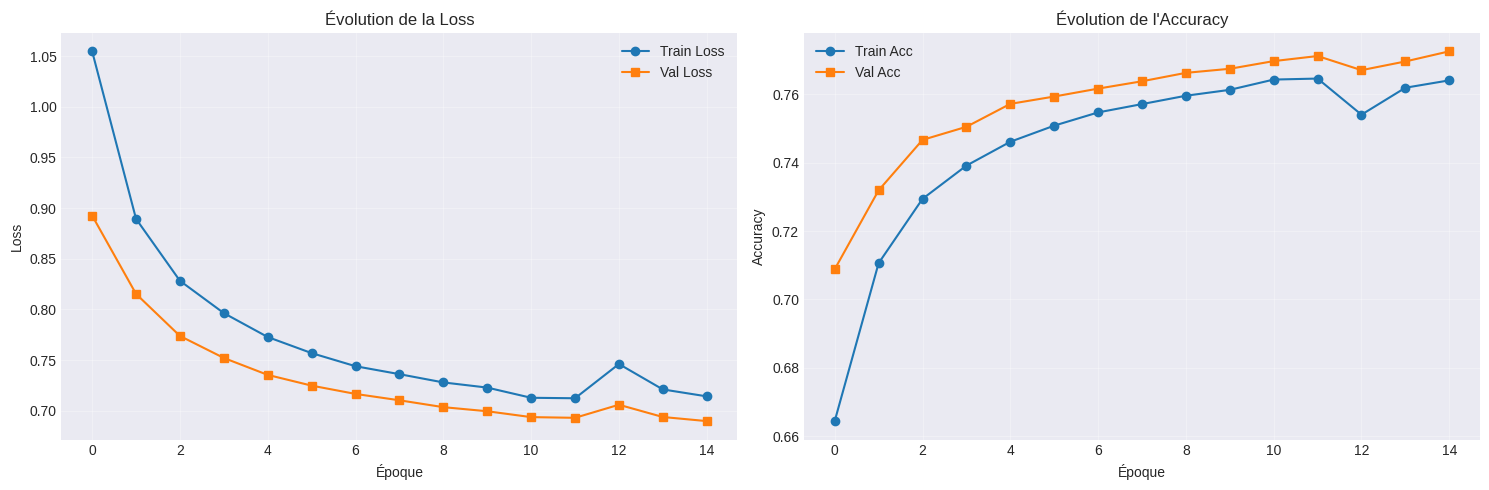

In [21]:
# Visualiser l'historique d'entraînement
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Époque')
axes[0].set_ylabel('Loss')
axes[0].set_title('Évolution de la Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Époque')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Évolution de l\'Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Génération de Musique

In [22]:
# Charger le meilleur modèle
checkpoint = torch.load('best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f" Meilleur modèle chargé (époque {checkpoint['epoch']+1})")
print(f"   Val Loss: {checkpoint['val_loss']:.4f}")
print(f"   Val Acc: {checkpoint['val_acc']:.4f}")

 Meilleur modèle chargé (époque 15)
   Val Loss: 0.6897
   Val Acc: 0.7726


In [23]:
# Fonction de génération
def generate_music(model, start_sequence, idx_to_char, char_to_idx, length=200, temperature=1.0, device='cpu'):
    """
    Génère une séquence musicale.
    """
    model.eval()
    model = model.to(device)
    
    current_seq = torch.tensor([start_sequence], dtype=torch.long).to(device)
    generated_indices = start_sequence.copy()
    
    with torch.no_grad():
        for _ in tqdm(range(length), desc="Génération", leave=False):
            output, _ = model(current_seq)
            logits = output[0, -1, :]
            
            # Temperature sampling
            logits = logits / temperature
            probs = F.softmax(logits, dim=-1)
            next_idx = torch.multinomial(probs, num_samples=1).item()
            
            generated_indices.append(next_idx)
            next_token = torch.tensor([[next_idx]], dtype=torch.long).to(device)
            current_seq = torch.cat([current_seq, next_token], dim=1)
    
    generated_text = ''.join([idx_to_char[idx] for idx in generated_indices])
    return generated_text

def create_start_sequence(text, char_to_idx, max_length=50):
    """Crée une séquence de départ."""
    if len(text) > max_length:
        text = text[:max_length]
    return [char_to_idx[ch] for ch in text if ch in char_to_idx]

In [24]:
# Générer de la musique!
start_text = "X:1\nT:Generated Irish Tune\nM:4/4\nL:1/8\nK:Gmaj\n"
start_seq = create_start_sequence(start_text, char_to_idx)

print(" Génération de musique...\n")
print("Texte de départ:")
print(start_text)


# Générer avec différentes températures
temperatures = [0.5, 0.8, 1.0]

for temp in temperatures:
    print(f"\n Génération avec température = {temp}")
    print("-"*80)
    
    generated = generate_music(
        model, start_seq, idx_to_char, char_to_idx,
        length=300, temperature=temp, device=device
    )
    
    print(generated)
    print("-"*80)

 Génération de musique...

Texte de départ:
X:1
T:Generated Irish Tune
M:4/4
L:1/8
K:Gmaj


 Génération avec température = 0.5
--------------------------------------------------------------------------------


Génération:   0%|          | 0/300 [00:00<?, ?it/s]

X:1
T:Generated Irish Tune
M:4/4
L:1/8
K:Gmaj
"^A" |:"G" B B B2 B2 | B B B B B2 |"C" c c"G" B B B2 |"D" A A A2 A2 | 
"G" B B B2 B2 |"D" A A A2 A2 |"G" B B B2 B2 | B A G B B B |"A7" A A A2 A2 |"D" A A A A A A | 
 A A A B A F |"G" G3 z B2 |"D" A A A A A A | A A A2 B2 | c A A A A A |"G" B B B2 d B |"D" A A A A A A | 
"G" B B B2 B B |"D" A A A A A 
--------------------------------------------------------------------------------

 Génération avec température = 0.8
--------------------------------------------------------------------------------


Génération:   0%|          | 0/300 [00:00<?, ?it/s]

X:1
T:Generated Irish Tune
M:4/4
L:1/8
K:Gmaj
"^A" g | f2 f2 d2 A2 | fe d2 f2 f2 | g3 f e2 d2 | c3 d c2 f2 | 
 e2 c2 e2 e2 | e4- e2 e2 | dc d2 e2 c2 | d6 || FG | A2 d2 A2 d2 | c2 A2 A2 F2 | G3 A B2 G2 | 
 F2 G2 A2 A2 | F3 E D2 (3(DEF) | G2 B2 d2 f2 | e2 d2 c2 B2 | A3 f e2 d2 | c2 d2 e2 c2 | d3 c B2 A2 | 
 G4 || (FD) FA d2 | c2 d2 d4 | c2 A2 A2 
--------------------------------------------------------------------------------

 Génération avec température = 1.0
--------------------------------------------------------------------------------


Génération:   0%|          | 0/300 [00:00<?, ?it/s]

X:1
T:Generated Irish Tune
M:4/4
L:1/8
K:Gmaj
 z a |"A" a2 e e c A | A =c A A c A | c d e =g f2 | e d e c/d/ e d | 
 c A/A/ A A B B |"G" B G2"A" B A2 |] A A A/c/ e e f |"G" g/a/ g e/e/ d/c/ d B |"A" A G A E E A | 
"A" (A3/2 B/) c e e (d/c/) | d c c e (e/f/) g |"A" a g a/g/ f (e/d/ d) |"A" (c/A/) A e e2 e | 
"D" (e/d/) A (f/e/) d A =G |"A" (A3/2
--------------------------------------------------------------------------------


In [25]:
# Générer plusieurs échantillons
print("\n Génération de 3 mélodies différentes:\n")

for i in range(3):
    
    print(f"Mélodie #{i+1}")
   
    
    generated = generate_music(
        model, start_seq, idx_to_char, char_to_idx,
        length=250, temperature=0.8, device=device
    )
    
    print(generated)
    print("\n Copiez cette notation et testez-la sur: https://www.abcjs.net/abcjs-editor.html")


 Génération de 3 mélodies différentes:

Mélodie #1


Génération:   0%|          | 0/250 [00:00<?, ?it/s]

X:1
T:Generated Irish Tune
M:4/4
L:1/8
K:Gmaj
 GE D2 DF | A2 B2 d2 | ED B,2 D2 | B,D F2 ED | A,2 E2 E2 | DA, A,2 FA | 
 AB A2 GA | B2 B2 AG | FG A2 B2 | GA Bc d2 | BA G2 F2 | ED D4 || d2 d2 cB | A2 G2 E2 | D2 D2 d2 | 
 Bc d2 Bc | d2 d2 d2 | ed cB AG | F2 G2 E2 | D2 D4 ||                         

 Copiez cette notation et testez-la sur: https://www.abcjs.net/abcjs-editor.html
Mélodie #2


Génération:   0%|          | 0/250 [00:00<?, ?it/s]

X:1
T:Generated Irish Tune
M:4/4
L:1/8
K:Gmaj
"^A" e | d B c B A G | F G A F E A | B c d e d c | B f e d c e | 
 d e A B/c/ B c | d2 d e d c | B c d c d A | d c B A G F | E D C D E G | F G A B c A | 
 E F G A B c | d c B/A/ G A B | c G F E F2 G | A B c d c B | A2 G F E D | C3/2 D/ E2 F2 | A3/2 G

 Copiez cette notation et testez-la sur: https://www.abcjs.net/abcjs-editor.html
Mélodie #3


Génération:   0%|          | 0/250 [00:00<?, ?it/s]

X:1
T:Generated Irish Tune
M:4/4
L:1/8
K:Gmaj
"^D in MS" A |"D" D/D/D D2 AA/A/ |"G" BA G2"D" F2 | AA A2 B2 | 
"D" A/A/A"G" B4 |"D" AA AG FA |"G" BB"D" A2"Em" G(F |"A" ED) D2 (F/G/) | A"D" (FD) D2 | 
"G" BB"^/" AG DE |"Am" F(F/E/)"D" D2 z :: A |"D" dd dd de |"D" fd d2"A" A(A/B/) |"D" d2 dd (3(def

 Copiez cette notation et testez-la sur: https://www.abcjs.net/abcjs-editor.html


##  Sauvegarde pour Téléchargement

In [26]:
# Sauvegarder quelques mélodies générées
with open('generated_tunes.txt', 'w', encoding='utf-8') as f:
    for i in range(5):
        generated = generate_music(
            model, start_seq, idx_to_char, char_to_idx,
            length=300, temperature=0.8, device=device
        )
        f.write(f"\n{'='*80}\n")
        f.write(f"Tune #{i+1}\n")
        f.write(f"{'='*80}\n")
        f.write(generated)
        f.write("\n")

print(" 5 mélodies sauvegardées dans 'generated_tunes.txt'")
print("   Vous pouvez télécharger ce fichier depuis Kaggle!")

Génération:   0%|          | 0/300 [00:00<?, ?it/s]

Génération:   0%|          | 0/300 [00:00<?, ?it/s]

Génération:   0%|          | 0/300 [00:00<?, ?it/s]

Génération:   0%|          | 0/300 [00:00<?, ?it/s]

Génération:   0%|          | 0/300 [00:00<?, ?it/s]

 5 mélodies sauvegardées dans 'generated_tunes.txt'
   Vous pouvez télécharger ce fichier depuis Kaggle!


##  Résumé Final

In [27]:

print(" TP RNN - GÉNÉRATION DE MUSIQUE ABC - TERMINÉ!")


print("\n Dataset:")
print(f"   - {len(train_data):,} chansons d'entraînement")
print(f"   - {len(validation_data):,} chansons de validation")
print(f"   - Vocabulaire: {vocab_size} caractères")
print(f"   - Longueur max: {MAX_LENGTH} caractères")

print("\n Modèle:")
print(f"   - Architecture: LSTM")
print(f"   - Embedding: {EMBEDDING_DIM} dimensions")
print(f"   - Hidden size: {HIDDEN_SIZE}")
print(f"   - Layers: {NUM_LAYERS}")
print(f"   - Paramètres: {num_params:,}")

print("\n Entraînement:")
print(f"   - Époques: {len(history['train_loss'])}")
print(f"   - Meilleure val loss: {best_val_loss:.4f}")
print(f"   - Temps total: {total_time/60:.2f} minutes")
print(f"   - Device: {device}")

print("\n Génération:")
print(f"   - Stratégies: Temperature sampling")
print(f"   - Fichier: generated_tunes.txt")

print("\n Prochaines étapes:")
print("   1. Télécharger 'best_model.pt' et 'generated_tunes.txt'")
print("   2. Tester les mélodies sur: https://www.abcjs.net/abcjs-editor.html")
print("   3. Expérimenter avec différentes températures")



 TP RNN - GÉNÉRATION DE MUSIQUE ABC - TERMINÉ!

 Dataset:
   - 214,122 chansons d'entraînement
   - 2,162 chansons de validation
   - Vocabulaire: 95 caractères
   - Longueur max: 300 caractères

 Modèle:
   - Architecture: LSTM
   - Embedding: 256 dimensions
   - Hidden size: 512
   - Layers: 2
   - Paramètres: 3,751,263

 Entraînement:
   - Époques: 15
   - Meilleure val loss: 0.6897
   - Temps total: 16.40 minutes
   - Device: cuda

 Génération:
   - Stratégies: Temperature sampling
   - Fichier: generated_tunes.txt

 Prochaines étapes:
   1. Télécharger 'best_model.pt' et 'generated_tunes.txt'
   2. Tester les mélodies sur: https://www.abcjs.net/abcjs-editor.html
   3. Expérimenter avec différentes températures
